# Generate graph from Poisoning results

In [1]:
import pandas as pd 
import json
from pprint import pprint
import requests
from datetime import date
import time
import datetime

import cfscrape
from lxml import etree
from bs4 import BeautifulSoup
import re
import requests
from pandas.io.json import json_normalize
import json
from datetime import datetime
import numpy as np
import os
import paramiko

import matplotlib.pyplot as plt

# Globals

In [2]:
DATASET_DIR = "./poison-baseline/"   # .stat files from vp-cli.py
CSV_OUT_FILE = './poison-baseline.csv'
PNG_FILE = './poison-baseline.png'

# Functions

In [3]:
'''
    Return true if all elements in array are equal (useful to check prepend)
'''
def all_equal_elem_array(lst):
    return lst[:-1] == lst[1:]

In [4]:
'''
    Convert aspath in format (xx_xx_xx) to an array of asn
'''
def aspath_to_array(aspath):
    pattern = '\d+_?'
    aslist = re.findall(pattern, aspath)
    for i, element in enumerate(aslist):
        aslist[i] = element.replace('_','')
    return aslist
    
    

In [5]:
'''
    Verify is aspath is poisoned or no (ex. normal pepend)
'''
def is_poisoned_aspath (aspath):
    ##aspath='1149_16735_1149'
    
    # Check if is path or string
    for character in (aspath):
        if not (character.isdigit() or character == '_'):
            #print ('Not valid AS-Path ->', aspath)
            return False
    
    # Convert aspath to array
    aslist = aspath_to_array(aspath)
    #print(aslist, aslist[0],aslist[-1])
    
    # 1st and last are equal
    if len(aslist)> 2 and aslist[0]==aslist[-1]:
        if all_equal_elem_array(aslist):
            #print ('AS-Path prepend ->', aspath)
            return False
        else:
            #print ('poison->', aspath)
            return True
    else:
        #print('Regular AS-Path->', aspath)
        return False

In [6]:
'''
    Extract aspath from filename returning in fomat xx_xx_xx 
'''
def extract_aspath_from_filename (fname):
    #fname = 'POISON_1149_16735_1149_PINGER-us-mia_DRAIN-nodrain_poa-lnd-mia_2021-04-20-08-37.csv.stats'
    aspath = re.search('POISON_(.+)_PINGER', fname)
    pattern = '\d+_?'
    
    if aspath:
        found = aspath.group(1)
        #print (found)
        return (found)
        #var = re.findall(pattern, found)
        #for i in var:
        #    print (i.replace('_',''))
    else:
        return 'ASPath_not_found'
  

In [7]:
def which_policy_from_aspath(aspath):
    
    # For now just return aspath
    return aspath
    
    if is_poisoned_aspath(aspath):        
        # return just poison asn in the middle
        #asns = aspath_to_array(aspath)
        #policy = '_'.join(asns[1:-1])
        
        print('poison  -> ', asns, policy)
        
    else:
        # prepend or baseline return itself
        policy = aspath
        #print('not poison -->', policy)

    return policy
    

In [8]:
'''
    read statistics files from verfploeter/vp-cli.py getting percentages of values
    receive: Stats file from vp-cli.py
    return:  sites
'''

def read_stats(file):
    #file='POISON_1149_16735_1149_PINGER-us-mia_DRAIN-nodrain_poa-lnd-mia_2021-04-20-08-37.csv.stats'
    f = open(file,"r")
    for x in f:
        #print(x)
        if 'lnd' in x:
            aux=x.rsplit('|',1)[1]
            #print (aux[0],'xxx', aux[1])
            aux=aux.rsplit('-',1)[1]
            aux=aux.rsplit('%',1)[0]
            #print(aux)
            lnd=int(aux)
        if 'poa' in x:
            aux=x.rsplit('|',1)[1]
            aux=aux.rsplit('-',1)[1]
            aux=aux.rsplit('%',1)[0]
            poa=int(aux)
        if 'mia' in x:
            aux=x.rsplit('|',1)[1]
            aux=aux.rsplit('-',1)[1]
            aux=aux.rsplit('%',1)[0]
            mia=int(aux)
    #print('mia',mia,'poa',poa,'lnd',lnd)
    return lnd, mia, poa

# Main

In [9]:
# Read all .stat files to DF
i=0
headers = ['policy', 'lnd', 'mia', 'poa']
df=pd.DataFrame(columns=headers)

# search for .stat files on dataset_dir
for file in os.listdir(DATASET_DIR):
    #print ('file ===>',fname)
    print (extract_aspath_from_filename(file))
    
    if not '/' in file:
        #print("Missing directory - suposing local!")
        fname = file
    else: 
        fname = file.rsplit('/',1)[1]
        
    if re.match(r"POISON_(.*)csv.stats", fname):
        #print ('file ===>',fname)

        aux = re.search('POISON_(.*)_PINGER-(.*)_DRAIN-(.*)_(.*)_(.*).csv.stats',file)
        
        aspath = extract_aspath_from_filename(fname)    
        policy = which_policy_from_aspath(aspath)
        
        pinger= aux[2]
        drain = aux[3]
        sites = aux[4]
        fdate = aux[5]
        
        lnd, mia, poa = read_stats(DATASET_DIR+fname)
        values = [policy, lnd, mia, poa]
        zipped = zip(headers, values)
        a_dictionary = dict(zipped)
        #print ('====>', a_dictionary)
        df = df.append(a_dictionary, ignore_index=True)

    #print ("Policy:",policy, "Pinger:", pinger," Drain:", drain, " Sites:", sites, "Date:", fdate, "ASPath:", aspath)

1149_12953_1149
1149_1149_1149
1149_63221_24115_1149
1149_6939_1149
1149_2914_1149
1149_262589_1149
baseline
1149_1239_1149
1149_1251_1149
1149_63221_1149
1149_6453_1149
1149_6461_1149
1149_24115_1149
1149_1149
1149_5511_1149
1149_3257_1149
1149_174_1149
1149_16735_1149
1149_701_1149
1149_7018_1149
1149_3356_1149
1149_1916_1149
1149_6762_1149
1149_1299_1149
1149_1273_1149
1149_3320_1149


In [10]:
# Prepare DF to plot
#df=df.sort_values('mia')
df=df.sort_values(['mia','policy'],ascending=[False, True])
df=df.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
df=df.set_index('policy')
df.head(2)

,lnd,mia,poa
policy,,,
baseline,57,20,21
1149_1149,68,8,22


In [11]:
#df.index[::-1]
df.index

Index(['baseline', '1149_1149', '1149_1149_1149', '1149_12953_1149',
       '1149_16735_1149', '1149_1916_1149', '1149_262589_1149',
       '1149_63221_1149', '1149_1251_1149', '1149_1273_1149',
       '1149_24115_1149', '1149_63221_24115_1149', '1149_6461_1149',
       '1149_1239_1149', '1149_1299_1149', '1149_174_1149', '1149_2914_1149',
       '1149_3257_1149', '1149_3320_1149', '1149_3356_1149', '1149_5511_1149',
       '1149_6453_1149', '1149_6762_1149', '1149_6939_1149', '1149_7018_1149',
       '1149_701_1149'],
      dtype='object', name='policy')

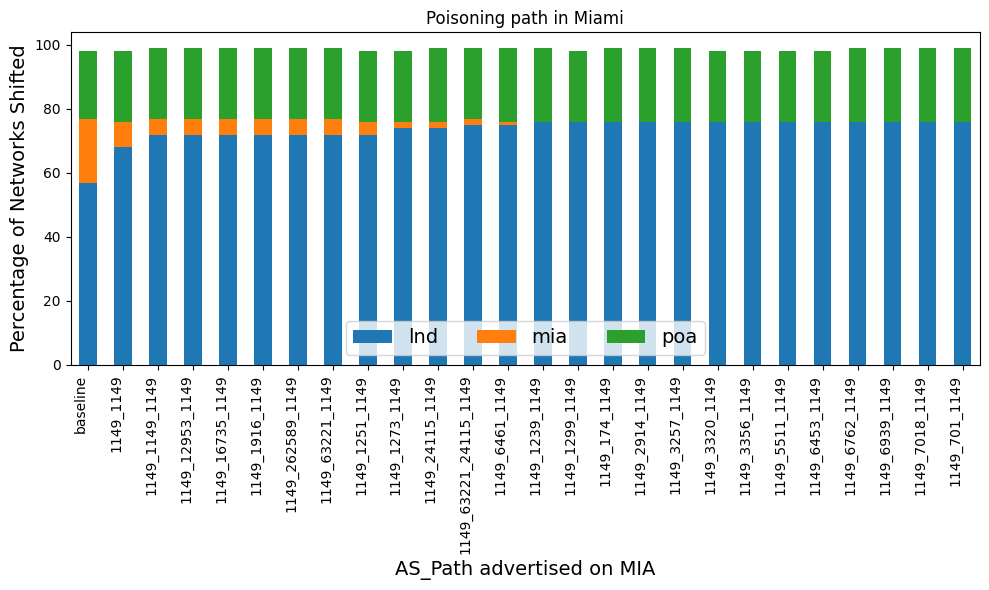

In [12]:
# Plot stackbar to sites poisoned

from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [10, 6]

# creates a stacked bar plot
df.plot(kind='bar', stacked=True)
plt.title("Poisoning path in Miami")
plt.xlabel("AS_Path advertised on MIA", fontsize='14')
plt.ylabel('Percentage of Networks Shifted', fontsize='14')
plt.legend(loc='lower center', ncol=3, fontsize='14')
plt.tight_layout()
plt.xticks(rotation=90,ha='right')
plt.show()
#plt.savefig(PNG_FILE)


In [15]:
# save DF to CSV
#df=df.reset_index(drop=False)
#df.to_csv(CSV_OUT_FILE,index=False)


In [14]:
# End of file